# Data exploration

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import random
from IPython.display import HTML

sys.path.append(os.path.join(os.getcwd(), 'utils'))

from utils.data_loading import *
from utils.data_processing import *
from utils.regression import *
from utils.animation import *
from utils.metrics import *
from utils.pipeline import *

# autoreload
%reload_ext autoreload
%autoreload 2

# Get the current working directory
current_dir = os.getcwd()

# Define the path to the data
data_path = os.path.join(current_dir, 'data')

print(f"Data path: {data_path}")

Data path: /Users/lharriso/Documents/GitHub/gm4cs-l/data


In [2]:
# Load the data
data = load_data(data_path, 'ssp585_time_series.pkl')

Loading data from ssp585_time_series.pkl
Data loaded successfully.


In [3]:
# Print the keys of the data (only the first 5)
print(f"Keys of the data: {list(data.keys())[:5]}")

Keys of the data: ['ICON-ESM-LR', 'EC-Earth3', 'EC-Earth3-Veg-LR', 'FIO-ESM-2-0', 'CMCC-CM2-SR5']


In [4]:
# Keep only models which have more than 4 runs (>= 4 runs)
filtered_data = filter_data(data)

Filtering data...


100%|██████████| 72/72 [00:00<00:00, 52474.35it/s]

Data filtered. Kept 34 models


## Plot a time stamp for a randomly chosen model

In [5]:
filtered_data.keys()

dict_keys(['ICON-ESM-LR', 'EC-Earth3', 'CMCC-CM2-SR5', 'ACCESS-CM2', 'CESM2', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'GISS-E2-2-G', 'CNRM-CM6-1', 'CanESM5-1', 'E3SM-2-0-NARRM', 'HadGEM3-GC31-LL', 'MIROC-ES2L', 'GISS-E2-1-H', 'E3SM-2-0', 'GISS-E2-1-G', 'EC-Earth3-Veg', 'ACCESS-ESM1-5', 'HadGEM3-GC31-MM', 'FGOALS-g3', 'E3SM-1-0', 'MPI-ESM1-2-HR', 'CanESM5', 'CAS-ESM2-0', 'MIROC6', 'NESM3', 'GISS-E2-2-H', 'MPI-ESM1-2-LR', 'AWI-CM-1-1-MR', 'UKESM1-0-LL', 'NorCPM1', 'INM-CM5-0', 'MRI-ESM2-0', 'CESM2-FV2'])

In [6]:
# chose a key randomly
example_model = 'CanESM5-1'
example_model_data = filtered_data[example_model]
print(f"Randomly selected model: {example_model}, which has {len(example_model_data)} runs.")

Randomly selected model: CanESM5-1, which has 72 runs.


In [7]:
first_example_model_run = example_model_data[list(example_model_data.keys())[0]]
first_example_model_run.shape # Shape: (Time x Latitude x Longitude)

(165, 72, 144)

In [8]:
random_timestamp = random.randint(0, first_example_model_run.shape[0])
data_to_plot = first_example_model_run[random_timestamp, :, :]
print(f"Random timestamp: {random_timestamp}")

Random timestamp: 94


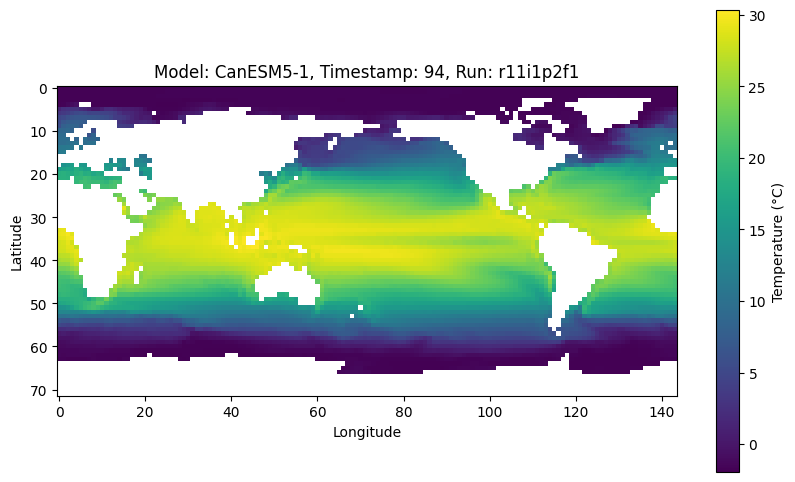

In [9]:
# Plot the data
# Create a colormap that sets NaN values to a specific color (e.g., gray)
plt.figure(figsize=(10, 6))
plt.imshow(data_to_plot, cmap='viridis') # Places the origin in the lower left
plt.colorbar(label='Temperature (°C)')
plt.title(f'Model: {example_model}, Timestamp: {random_timestamp}, Run: {list(example_model_data.keys())[0]}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Get a mask of all the grids where there is at least one NaN value (for all models and all runs)

In [10]:
# Create a NaN mask
nan_mask = create_nan_mask(filtered_data)
print(f"The grid has a shape of: {nan_mask.shape}.")

Creating NaN mask...


100%|██████████| 34/34 [00:01<00:00, 17.13it/s]

NaN mask created.
The grid has a shape of: (72, 144).


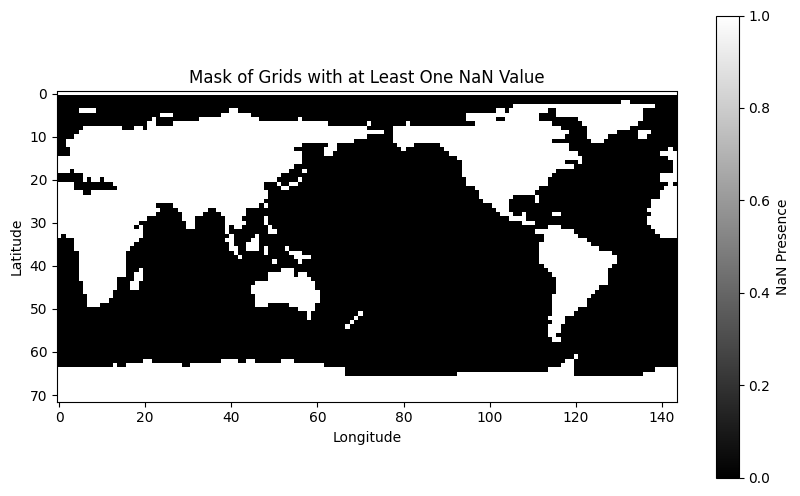

In [11]:
# Plot the mask
plt.figure(figsize=(10, 6))
plt.imshow(nan_mask, cmap='gray')
plt.colorbar(label='NaN Presence')
plt.title('Mask of Grids with at Least One NaN Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Remove all grid cells that contain at least one NaN

In [12]:
nan_filtered_data = mask_out_nans(filtered_data, nan_mask)

Masking out NaN values...


100%|██████████| 34/34 [00:02<00:00, 13.22it/s]

NaN values masked out.


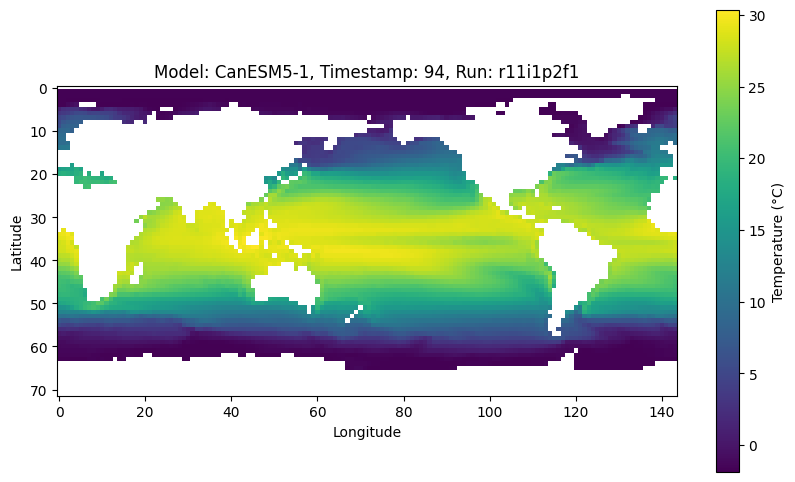

In [13]:
# Example of plotting a random run after applying the NaN filter
example_model_data = nan_filtered_data[example_model]
chosen_run = list(example_model_data.keys())[0]
example_model_run = example_model_data[chosen_run]

nan_removed_data_sample = example_model_run[random_timestamp, :, :]

# Plot the data
plt.figure(figsize=(10, 6))
plt.imshow(nan_removed_data_sample, cmap='viridis')  # Plotting the first time step as an example
plt.colorbar(label='Temperature (°C)')
plt.title(f'Model: {example_model}, Timestamp: {random_timestamp}, Run: {chosen_run}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Centering of the data for each cell

In [14]:
# Center the data
centered_data = center_data(nan_filtered_data)

  0%|          | 0/34 [00:00<?, ?it/s]/Users/lharriso/Documents/GitHub/gm4cs-l/utils/data_processing.py:71: RuntimeWarning: Mean of empty slice
  grid_average = np.nanmean(runs_stack, axis=(0, 1))
/opt/anaconda3/envs/main/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lharriso/Documents/GitHub/gm4cs-l/utils/data_processing.py:74: RuntimeWarning: Mean of empty slice
  forced_response = np.nanmean(np.stack(list(centered_data[model].values()), axis=0), axis=0)
100%|██████████| 34/34 [00:18<00:00,  1.86it/s]


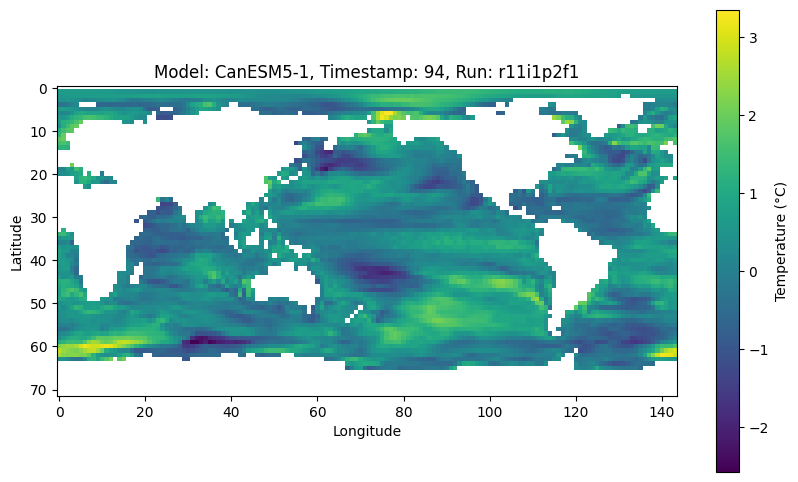

In [15]:
# Example of plotting a random run after applying the NaN filter
data_to_plot = centered_data[example_model][chosen_run]

# Plot the data
plt.figure(figsize=(10, 6))
plt.imshow(data_to_plot[random_timestamp, :, :], cmap='viridis')  # Plotting the first time step as an example
plt.colorbar(label='Temperature (°C)')
plt.title(f'Model: {example_model}, Timestamp: {random_timestamp}, Run: {chosen_run}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Displaying the forced response and runs for grid spot: [53 12]


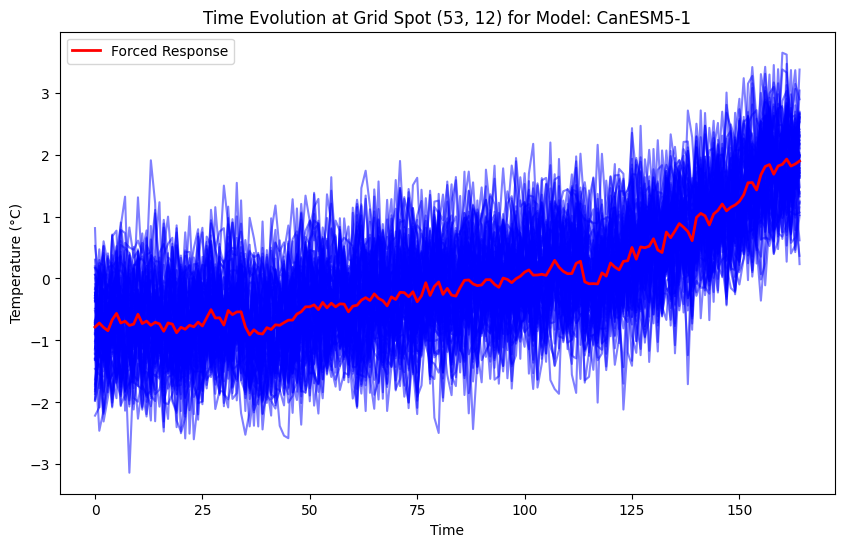

In [16]:
# Example of plotting the forced response for a random model
valid_grid_spots = np.argwhere(~nan_mask)
random_grid_spot = valid_grid_spots[random.randint(0, len(valid_grid_spots))]
print(f"Displaying the forced response and runs for grid spot: {random_grid_spot}")

# Data for each run
time_series_data = {run : centered_data[example_model][run][:, random_grid_spot[0], random_grid_spot[1]] for run in centered_data[example_model]}
forced_response_data = centered_data[example_model]['forced_response'][:, random_grid_spot[0], random_grid_spot[1]]

# Plot the time series data for all runs and the forced response
plt.figure(figsize=(10, 6))
for data in time_series_data.values():
    plt.plot(data, color='blue', alpha=0.5)
plt.plot(forced_response_data, color='red', label='Forced Response', linewidth=2)
plt.title(f'Time Evolution at Grid Spot ({random_grid_spot[0]}, {random_grid_spot[1]}) for Model: {example_model}')
plt.xlabel('Time') # Need to change this
plt.ylabel('Temperature (°C)')
# plt.ylim(-2,4)
plt.legend()
plt.show()

In [17]:
# The number of runs for the example model
print(f"Number of runs for the example model: {len(centered_data[example_model])}")

Number of runs for the example model: 73


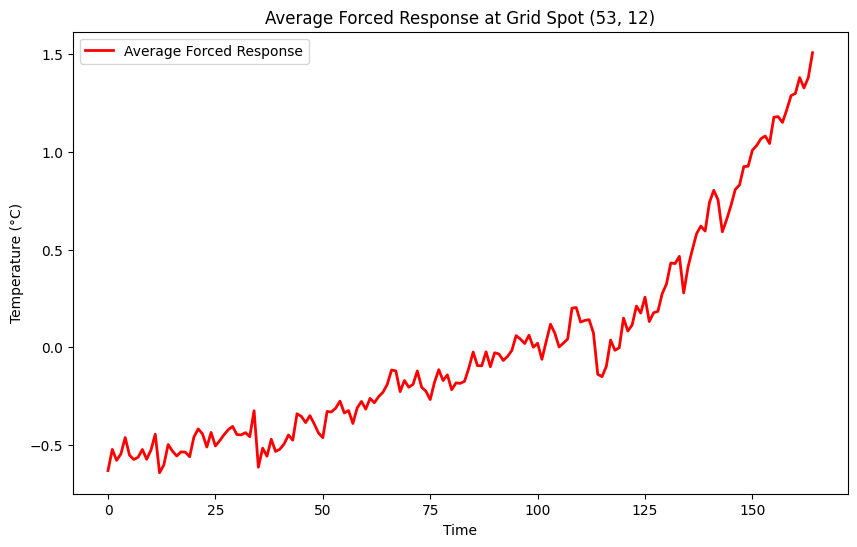

In [18]:
# Plot the average forced response of all models for that given grid spot
average_forced_response = np.mean([centered_data[model]['forced_response'][:, random_grid_spot[0], random_grid_spot[1]] for model in centered_data], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(average_forced_response, color='red', label='Average Forced Response', linewidth=2)
plt.title(f'Average Forced Response at Grid Spot ({random_grid_spot[0]}, {random_grid_spot[1]})')
plt.xlabel('Time') # Need to change this
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

## Now we will animate the data for the randomly chosen model

In [20]:
# Create the animation
title = 'Ground Truth Data over Time'
animation = animate_data(data_to_plot, title, interval = 200)

# Display the animation
HTML(animation.to_html5_video())